<span style="font-size:28px; color:Purple;"> **Appendix** </span>

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
pd.set_option("display.width", 1000)

<span style="font-size:18px; color:Black;"> **Download monthly returns data (since 2000) for US equities, US 10Yr treasury bonds, US REITs and US commodities** </span>

In [2]:
# Define tickers for each asset class
tickers = {
    'US_10Yr_Treasury': 'IEF',  # iShares 7-10 Year Treasury Bond ETF
    'US_REITs': 'IYR',          # iShares U.S. Real Estate ETF
    'US_Equities': 'SPY',       # US Equities (S&P 500 ETF)
    'US_Commodities':'^SPGSCI'  # S&P GSCI Index
}
start_date='2000-01-01'
end_date = '2025-04-05'

data = yf.download(list(tickers.values()), start=start_date, end=end_date, interval='1mo')
prices = data['Close']
# Calculate monthly returns
returns = prices.pct_change().dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


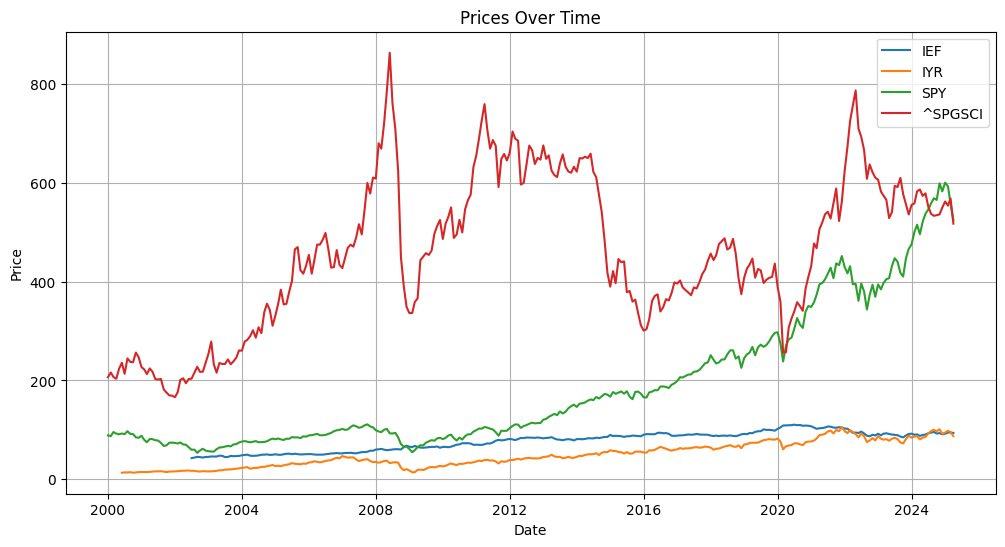

In [3]:
plt.figure(figsize=(12, 6))
for asset in prices.columns:
    plt.plot(prices.index, prices[asset], label=asset)

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Prices Over Time")
plt.legend()
plt.grid(True)
plt.show()

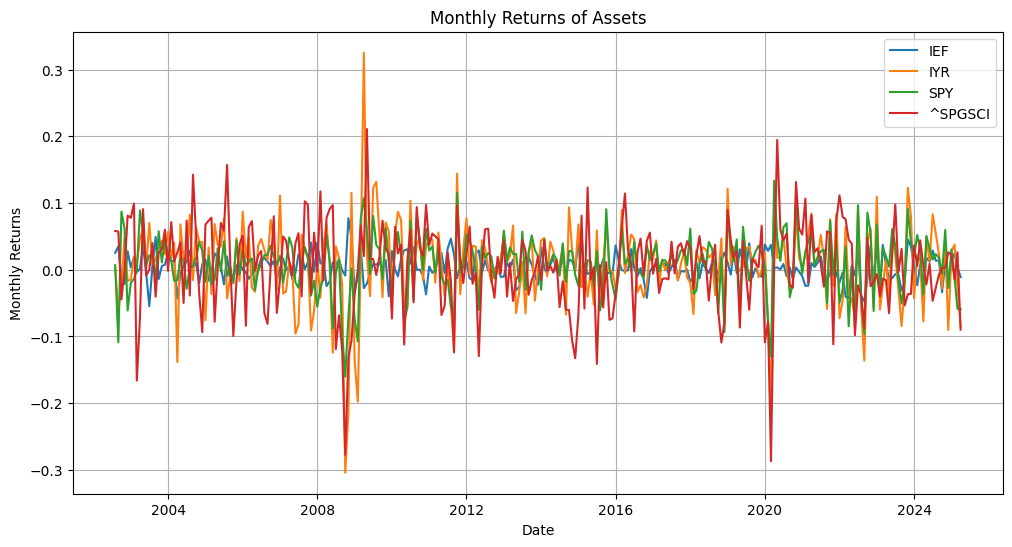

In [4]:
plt.figure(figsize=(12, 6))
for ticker in returns.columns:
    plt.plot(returns.index, returns[ticker], label=ticker)

plt.xlabel("Date")
plt.ylabel("Monthly Returns")
plt.title("Monthly Returns of Assets")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# Check for missing data
missing_data = returns.isna().sum()
if missing_data.sum() > 0:
    print("\nMissing data in each column:")
    print(missing_data)
    print("\nDropping rows with missing data...")
    returns = returns.dropna()
    print(f"Remaining observations: {len(returns)}")

In [6]:
# Print data range info
print(f"Data ranges from {returns.index[0].strftime('%Y-%m-%d')} to {returns.index[-1].strftime('%Y-%m-%d')}")
print(f"Number of monthly observations: {len(returns)}")

Data ranges from 2002-08-01 to 2025-04-01
Number of monthly observations: 273


In [7]:
prices.tail()

Ticker,IEF,IYR,SPY,^SPGSCI
Date,,,,
2024-12-01,91.015945,91.952286,582.362183,549.640015
2025-01-01,92.161766,94.465858,600.015015,561.919983
2025-02-01,94.440552,98.042450,592.397949,553.580017
2025-03-01,94.791733,95.392387,557.712280,568.080017
2025-04-01,93.740242,87.320000,524.580017,517.039978


In [8]:
returns.head()

Ticker,IEF,IYR,SPY,^SPGSCI
Date,,,,
2002-08-01,0.025206,0.003611,0.006801,0.058161
2002-09-01,0.034989,-0.062837,-0.108847,0.057148
2002-10-01,-0.012032,-0.026617,0.087136,-0.044434
2002-11-01,-0.021359,0.048406,0.061681,0.000414
2002-12-01,0.027649,-0.016790,-0.061184,0.081100


In [9]:
returns.tail()

Ticker,IEF,IYR,SPY,^SPGSCI
Date,,,,
2024-12-01,-0.025775,-0.090412,-0.027334,0.026003
2025-01-01,0.012589,0.027336,0.030312,0.022342
2025-02-01,0.024726,0.037861,-0.012695,-0.014842
2025-03-01,0.003719,-0.027030,-0.058551,0.026193
2025-04-01,-0.011093,-0.084623,-0.059407,-0.089847


<span style="font-size:18px; color:Black;"> **Use full historical return/covariance assumptions to setup portfolio optimization with following objectives (no short constraint):**<br>
Maximize return subject to annualized volatility less than 10% <br>
Minimize volatility subject to annualized return more than 4%  <br>
Maximize Sharpe Ratio </span>

In [10]:
#Compute geometric annualized returns PER ASSET
no_of_months_annual = 12
no_of_months_data = returns.shape[0]  # Total days in dataset
annualized_returns = (1 + returns).prod()**(no_of_months_annual / no_of_months_data) - 1

#Compute annualized covariance matrix
annualized_covariance_matrix = returns.cov() * no_of_months_annual

# Print results
print("\nAnnualized Returns Per Asset:\n", annualized_returns)
print("\nAnnualized Covariance Matrix:\n", annualized_covariance_matrix)


Annualized Returns Per Asset:
 Ticker
IEF        0.035062
IYR        0.074290
SPY        0.100271
^SPGSCI    0.041861
dtype: float64

Annualized Covariance Matrix:
 Ticker        IEF       IYR       SPY   ^SPGSCI
Ticker                                         
IEF      0.004576  0.001663 -0.001000 -0.003571
IYR      0.001663  0.045142  0.023892  0.011135
SPY     -0.001000  0.023892  0.022792  0.012933
^SPGSCI -0.003571  0.011135  0.012933  0.051012


In [11]:
returns.std()

,0
Ticker,
IEF,0.019527
IYR,0.061334
SPY,0.043581
^SPGSCI,0.065200


In [12]:
def mean_portfolio(weights, annualized_returns):
    portfolio_return_ans = annualized_returns.dot(weights)
    return portfolio_return_ans

def std_portfolio(weights, annualized_covariance_matrix):
    portfolio_volatility_ans = np.sqrt(np.dot(weights.T, np.dot(annualized_covariance_matrix, weights)))
    return portfolio_volatility_ans

def sharpe_ratio(weights, annualized_returns, annualized_covariance_matrix):

    portfolio_return = np.dot(weights, annualized_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(annualized_covariance_matrix, weights)))
    sharpe = portfolio_return / portfolio_volatility
    return -sharpe

In [13]:
def run_optimization (annualized_returns, annualized_covariance_matrix):
    num_assets = returns.shape[1]
    init_weights = np.array([1/num_assets] * num_assets)  # Initial guess (equal weights)
    bounds = tuple((0, 1) for _ in range(num_assets))   # no shorting constraint

    constraint1 = (
        {'type': 'ineq', 'fun': lambda x: 0.10 - std_portfolio(x, annualized_covariance_matrix)}, #portfolio volatility<target volatility
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    )

    constraint2 = (
        {'type': 'ineq', 'fun': lambda x: mean_portfolio(x, annualized_returns) - 0.04},  #porfolio mean return>target return
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    )

    constraint3 = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    )

    max_return_result = minimize(
        fun=lambda x: -mean_portfolio(x, annualized_returns),
        x0 = init_weights,
        method='SLSQP',
        bounds=bounds,
        constraints= constraint1
    )

    min_vol_result = minimize(
        fun=lambda x: std_portfolio(x, annualized_covariance_matrix),
        x0 = init_weights,
        method='SLSQP',
        bounds=bounds,
        constraints=constraint2
    )

    max_sharpe_result = minimize(
        fun=lambda x: sharpe_ratio(x, annualized_returns, annualized_covariance_matrix),
        x0 = init_weights,
        method='SLSQP',
        bounds=bounds,
        constraints=constraint3
    )

    portfolios = {
        'Max Return (Vol ≤ 10%)': {
            'weights': max_return_result['x'],
            'return': mean_portfolio(max_return_result.x, annualized_returns),
            'volatility': std_portfolio(max_return_result.x, annualized_covariance_matrix),
            'sharpe': (mean_portfolio(max_return_result.x, annualized_returns)) / std_portfolio(max_return_result.x, annualized_covariance_matrix)
        },
        'Min Volatility (Return ≥ 4%)': {
            'weights': min_vol_result['x'],
            'return': mean_portfolio(min_vol_result.x, annualized_returns),
            'volatility': std_portfolio(min_vol_result.x, annualized_covariance_matrix),
            'sharpe': (mean_portfolio(min_vol_result.x, annualized_returns)) / std_portfolio(min_vol_result.x, annualized_covariance_matrix)
        },
        'Max Sharpe Ratio': {
            'weights': max_sharpe_result['x'],
            'return': mean_portfolio(max_sharpe_result.x, annualized_returns),
            'volatility': std_portfolio(max_sharpe_result.x, annualized_covariance_matrix),
            'sharpe': (mean_portfolio(max_sharpe_result.x, annualized_returns)) / std_portfolio(max_sharpe_result.x, annualized_covariance_matrix)
        }
    }

    weight_ans = {
        'Max Return (Vol ≤ 10%)': max_return_result['x'],
        'Min Volatility (Return ≥ 4%)': min_vol_result['x'],
        'Max Sharpe Ratio': max_sharpe_result['x']
    }

    results = pd.DataFrame()
    asset_names = list(tickers.keys())
    for name, portfolio in portfolios.items():
        weights_dict = {asset: round(weight * 100, 2) for asset, weight in zip(asset_names, portfolio['weights'])}
        weights_dict['Return (%)'] = round(portfolio['return'] * 100, 2)
        weights_dict['Volatility (%)'] = round(portfolio['volatility'] * 100, 2)
        weights_dict['Sharpe Ratio'] = round(portfolio['sharpe'], 2)
        results[name] = pd.Series(weights_dict)

    print(results)
    return weight_ans

In [14]:
print("Optimization Results (Portfolio Weights in %):\n")
weight_ans = run_optimization (annualized_returns, annualized_covariance_matrix)

Optimization Results (Portfolio Weights in %):

                  Max Return (Vol ≤ 10%)  Min Volatility (Return ≥ 4%)  Max Sharpe Ratio
US_10Yr_Treasury                   34.03                         78.88             64.43
US_REITs                            0.00                          0.00              0.00
US_Equities                        65.97                         12.54             33.64
US_Commodities                      0.00                          8.58              1.93
Return (%)                          7.81                          4.38              5.71
Volatility (%)                     10.00                          5.64              6.44
Sharpe Ratio                        0.78                          0.78              0.89


<span style="font-size:18px; color:Black;"> **If assuming all assets have the same Sharpe Ratio, what are the optimization portfolios with these three objectives? Will the optimization results depend on the Sharpe Ratio assumption?** </span>

In [16]:
original_returns = annualized_returns.copy()
original_cov = annualized_covariance_matrix.copy()


In [17]:
def set_average_sharpe_ratio(returns_data, cov_matrix):

    # Adjusts asset returns so all assets have the same Sharpe ratio
    # using the average Sharpe ratio of the original assets

    volatilities = np.sqrt(np.diag(cov_matrix))
    original_sharpe_ratios = returns_data / volatilities
    avg_sharpe = np.mean(original_sharpe_ratios)
    print(f"Average Sharpe Ratio of assets: {avg_sharpe:.4f}")

    adjusted_returns = avg_sharpe * volatilities
    adjusted_returns_series = pd.Series(adjusted_returns, index=returns_data.index)
    return adjusted_returns_series

In [18]:
avg_sharpe_returns = set_average_sharpe_ratio(original_returns, original_cov)
print("\nComparison of Original vs. Adjusted Returns:")
comparison_df = pd.DataFrame({
    'Original Returns': original_returns,
    'Adjusted Returns': avg_sharpe_returns,
    'Volatility': np.sqrt(np.diag(original_cov)),
    'Original Sharpe': original_returns / np.sqrt(np.diag(original_cov)),
    'New Sharpe': avg_sharpe_returns / np.sqrt(np.diag(original_cov))
})
print(comparison_df.round(4))

Average Sharpe Ratio of assets: 0.4294

Comparison of Original vs. Adjusted Returns:
         Original Returns  Adjusted Returns  Volatility  Original Sharpe  New Sharpe
Ticker                                                                              
IEF                0.0351            0.0290      0.0676           0.5183      0.4294
IYR                0.0743            0.0912      0.2125           0.3497      0.4294
SPY                0.1003            0.0648      0.1510           0.6642      0.4294
^SPGSCI            0.0419            0.0970      0.2259           0.1853      0.4294


In [19]:
print('Optimization Results assuming equal Sharpe ratios (Average sharpe ratio):\n')
weights = run_optimization (avg_sharpe_returns, annualized_covariance_matrix)

Optimization Results assuming equal Sharpe ratios (Average sharpe ratio):

                  Max Return (Vol ≤ 10%)  Min Volatility (Return ≥ 4%)  Max Sharpe Ratio
US_10Yr_Treasury                   43.06                         77.76             66.93
US_REITs                           25.85                          0.00              2.43
US_Equities                         0.00                         12.92             14.61
US_Commodities                     31.09                          9.32             16.03
Return (%)                          6.62                          4.00              4.67
Volatility (%)                     10.00                          5.64              6.19
Sharpe Ratio                        0.66                          0.71              0.75


In [20]:
def set_max_sharpe_ratio(returns_data, cov_matrix):
    # Adjusts asset returns so all assets have the same Sharpe ratio
    # using the maximum Sharpe ratio of the original assets

    volatilities = np.sqrt(np.diag(cov_matrix))
    original_sharpe_ratios = returns_data / volatilities
    max_sharpe = np.max(original_sharpe_ratios)
    max_sharpe = 0.4
    print(f"Maximum Sharpe Ratio of assets: {max_sharpe:.4f}")

    adjusted_returns = max_sharpe * volatilities
    adjusted_returns_series = pd.Series(adjusted_returns, index=returns_data.index)
    return adjusted_returns_series

In [21]:
max_sharpe_returns = set_max_sharpe_ratio(original_returns, original_cov)
print("\nComparison of Original vs. Adjusted Returns:")
comparison_df = pd.DataFrame({
    'Original Returns': original_returns,
    'Adjusted Returns': max_sharpe_returns,
    'Volatility': np.sqrt(np.diag(original_cov)),
    'Original Sharpe': original_returns / np.sqrt(np.diag(original_cov)),
    'New Sharpe': max_sharpe_returns / np.sqrt(np.diag(original_cov))
})
print(comparison_df.round(4))

Maximum Sharpe Ratio of assets: 0.4000

Comparison of Original vs. Adjusted Returns:
         Original Returns  Adjusted Returns  Volatility  Original Sharpe  New Sharpe
Ticker                                                                              
IEF                0.0351            0.0271      0.0676           0.5183         0.4
IYR                0.0743            0.0850      0.2125           0.3497         0.4
SPY                0.1003            0.0604      0.1510           0.6642         0.4
^SPGSCI            0.0419            0.0903      0.2259           0.1853         0.4


In [22]:
print('Optimization Results assuming equal Sharpe ratios (Max sharpe ratio):\n')
weights = run_optimization (avg_sharpe_returns, annualized_covariance_matrix)

Optimization Results assuming equal Sharpe ratios (Max sharpe ratio):

                  Max Return (Vol ≤ 10%)  Min Volatility (Return ≥ 4%)  Max Sharpe Ratio
US_10Yr_Treasury                   43.06                         77.76             66.93
US_REITs                           25.85                          0.00              2.43
US_Equities                         0.00                         12.92             14.61
US_Commodities                     31.09                          9.32             16.03
Return (%)                          6.62                          4.00              4.67
Volatility (%)                     10.00                          5.64              6.19
Sharpe Ratio                        0.66                          0.71              0.75


In [23]:
def plot_portfolio_weights(weights_data, asset_names, sharpe_ratios):

    weights_df = pd.DataFrame(weights_data, columns=asset_names, index=sharpe_ratios)

    plt.figure(figsize=(10, 6))
    for asset in asset_names:
        plt.plot(weights_df.index, weights_df[asset], label=asset)
    plt.xlabel('Assumed Sharpe Ratio')
    plt.ylabel('Portfolio Weight')
    plt.title('Portfolio Weights vs. Assumed Sharpe Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()

Portfolio weights for Maximimum sharpe ratio optimization across varying assumed Sharpe ratio


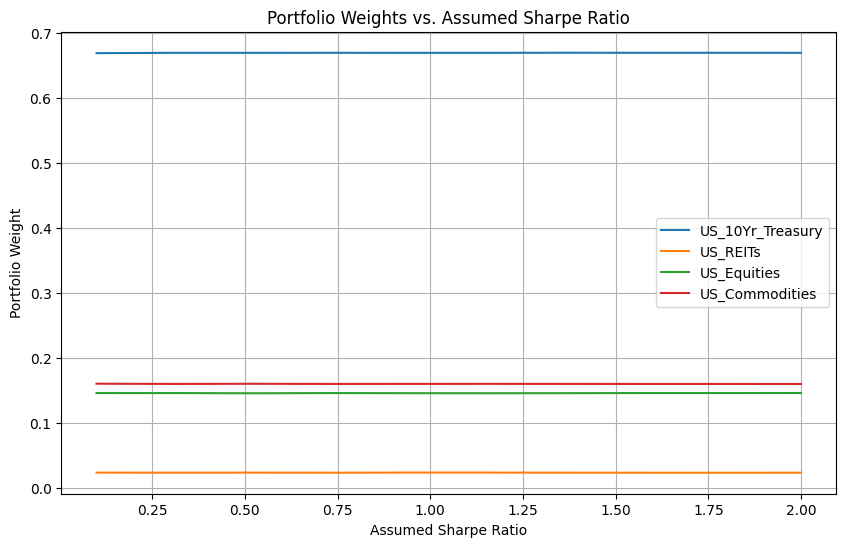

In [24]:
def max_sharpe_result_different_SR(sharpe_ratios, annualized_covariance_matrix, annualized_returns):
    asset_names = list(tickers.keys())
    num_assets = len(asset_names)
    weights_data = []

    for sharpe in sharpe_ratios:
        adjusted_returns = sharpe * np.sqrt(np.diag(annualized_covariance_matrix))
        adjusted_returns_series = pd.Series(adjusted_returns, index=annualized_returns.index)

        init_weights = np.array([1/num_assets] * num_assets)
        bounds = tuple((0, 1) for _ in range(num_assets))

        constraint3 = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

        max_sharpe_result = minimize(
            fun=lambda x: sharpe_ratio(x, adjusted_returns_series, annualized_covariance_matrix),
            x0 = init_weights,
            method='SLSQP',
            bounds=bounds,
            constraints=constraint3
        )

        weights_data.append(max_sharpe_result.x)
    print('Portfolio weights for Maximimum sharpe ratio optimization across varying assumed Sharpe ratio')
    plot_portfolio_weights(weights_data, asset_names, sharpe_ratios)

sharpe_ratios_to_test = np.linspace(0.1, 2, 10)
max_sharpe_result_different_SR(sharpe_ratios_to_test, annualized_covariance_matrix, annualized_returns)

Portfolio weights for Minimum volatility optimization across varying assumed Sharpe ratio


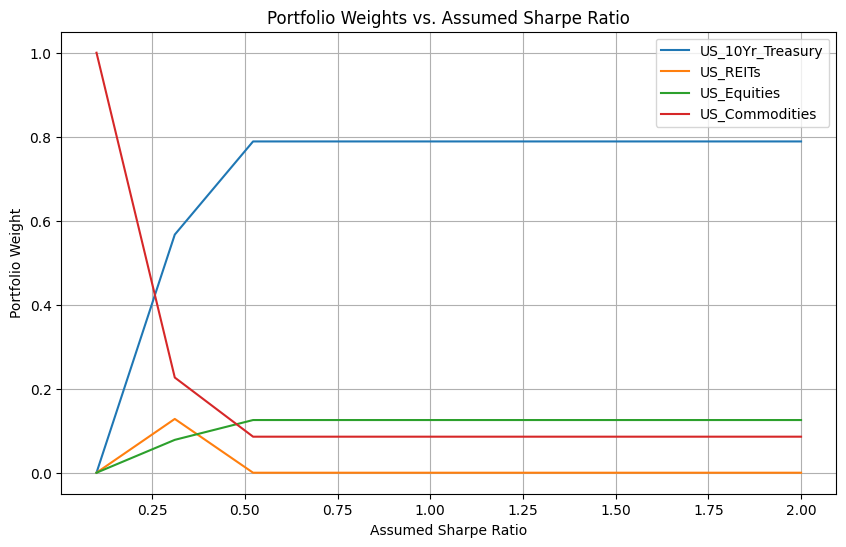

In [25]:
def min_vol_different_SR(sharpe_ratios, annualized_covariance_matrix, annualized_returns):
    asset_names = list(tickers.keys())
    num_assets = len(asset_names)
    weights_data = []

    for sharpe in sharpe_ratios:
        adjusted_returns = sharpe * np.sqrt(np.diag(annualized_covariance_matrix))
        adjusted_returns_series = pd.Series(adjusted_returns, index=annualized_returns.index)

        init_weights = np.array([1/num_assets] * num_assets)
        bounds = tuple((0, 1) for _ in range(num_assets))

        constraint2 = (
            {'type': 'ineq', 'fun': lambda x: mean_portfolio(x, adjusted_returns_series) - 0.04},  #porfolio mean return>target return
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        )

        min_vol_result = minimize(
            fun=lambda x: std_portfolio(x, annualized_covariance_matrix),
            x0 = init_weights,
            method='SLSQP',
            bounds=bounds,
            constraints=constraint2
        )
        weights_data.append(min_vol_result.x)

    print('Portfolio weights for Minimum volatility optimization across varying assumed Sharpe ratio')
    plot_portfolio_weights(weights_data, asset_names, sharpe_ratios)

sharpe_ratios_to_test = np.linspace(0.1, 2, 10)
min_vol_different_SR(sharpe_ratios_to_test, annualized_covariance_matrix, annualized_returns)

Portfolio weights for Maximum return optimization across varying assumed Sharpe ratio


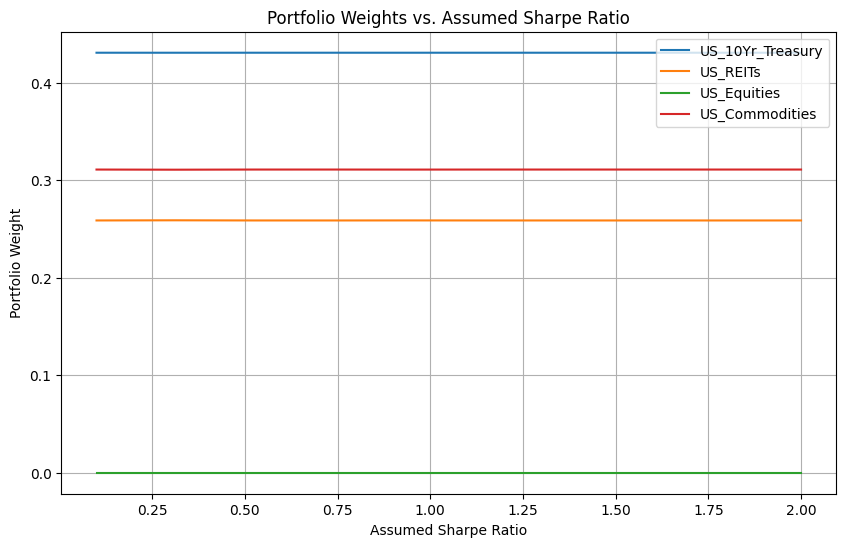

In [26]:
def max_return_different_SR(sharpe_ratios, annualized_covariance_matrix, annualized_returns):
    asset_names = list(tickers.keys())
    num_assets = len(asset_names)
    weights_data = []

    for sharpe in sharpe_ratios:
        adjusted_returns = sharpe * np.sqrt(np.diag(annualized_covariance_matrix))
        adjusted_returns_series = pd.Series(adjusted_returns, index=annualized_returns.index)

        init_weights = np.array([1/num_assets] * num_assets)
        bounds = tuple((0, 1) for _ in range(num_assets))

        constraint1 = (
            {'type': 'ineq', 'fun': lambda x: 0.10 - std_portfolio(x, annualized_covariance_matrix)}, #portfolio volatility<target volatility
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        )

        max_return_result = minimize(
            fun=lambda x: -mean_portfolio(x, adjusted_returns_series),
            x0 = init_weights,
            method='SLSQP',
            bounds=bounds,
            constraints= constraint1
        )

        weights_data.append(max_return_result.x)
    print('Portfolio weights for Maximum return optimization across varying assumed Sharpe ratio')
    plot_portfolio_weights(weights_data, asset_names, sharpe_ratios)

sharpe_ratios_to_test = np.linspace(0.1, 2, 10)
max_return_different_SR(sharpe_ratios_to_test, annualized_covariance_matrix, annualized_returns)

<span style="font-size:18px; color:Black;"> **Is there any regime change for the risk assumption observed from the historical data? If yes, what is the impact on the portfolio optimization results?** </span>

<Axes: title={'center': '12-Month Rolling Volatility'}, xlabel='Date'>

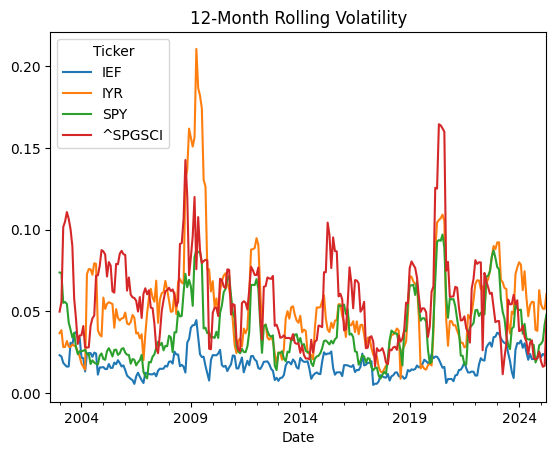

In [28]:
rolling_vol = returns.rolling(window=6).std()
rolling_vol.plot(title='12-Month Rolling Volatility')

In [29]:
# Step 1: Define your regimes
regimes = {
    'Before GFC': ('2002-08-01', '2006-12-31'),
    'During GFC': ('2007-01-01', '2009-12-31'),
    'After GFC to Before COVID': ('2010-01-01', '2019-12-31'),
    'During COVID': ('2020-01-01', '2021-12-31'),
    'After COVID': ('2022-01-01', '2025-04-01')
}

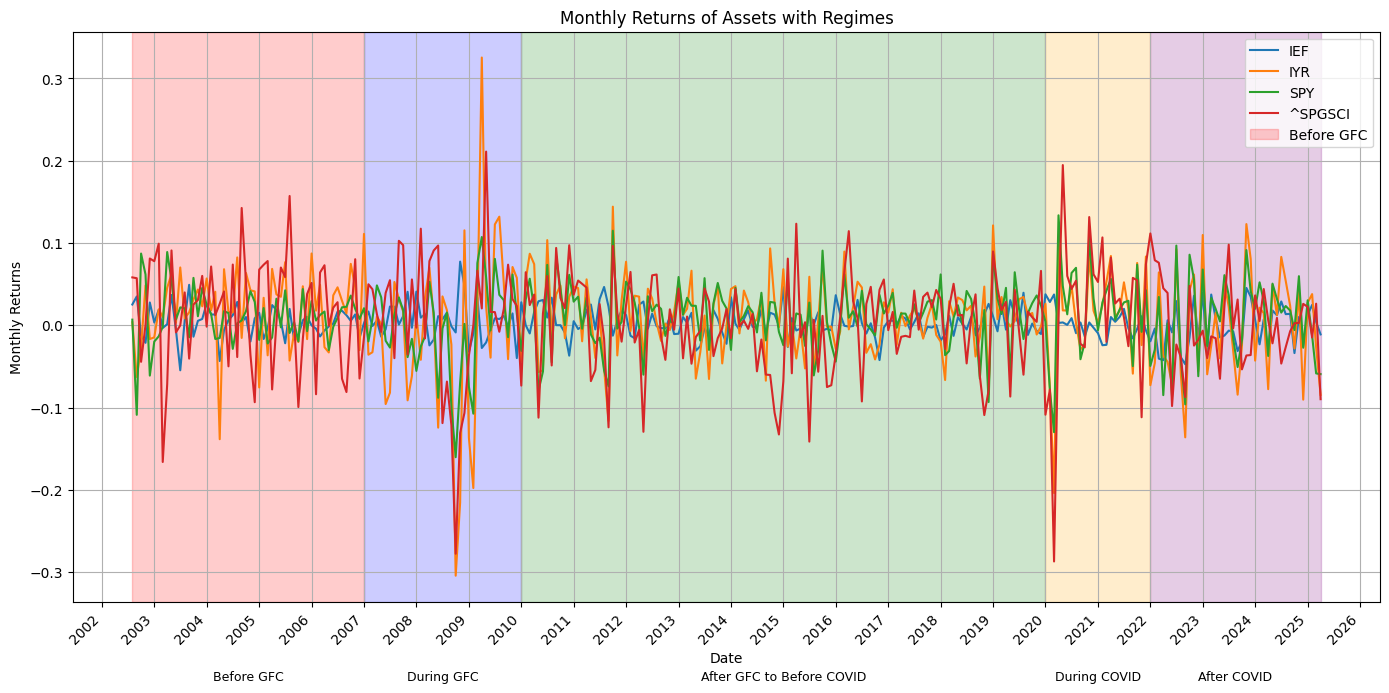

In [30]:
import matplotlib.dates as mdates
def plot_monthly_returns_with_regimes(returns, regimes):
    fig, ax = plt.subplots(figsize=(14, 7))

    for asset in returns.columns:
        ax.plot(returns.index, returns[asset], label=asset)

    # Color the background based on regimes
    for i, (regime_name, (start_date, end_date)) in enumerate(regimes.items()):
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)

        # Use a color cycle for better visual distinction
        colors = ['red', 'blue', 'green', 'orange', 'purple']
        color = colors[i % len(colors)]

        ax.axvspan(start_date, end_date, color=color, alpha=0.2, label=regime_name if i == 0 else "")

        # Add regime label below the year on the x-axis
        # Find a suitable x-coordinate within the regime's span
        regime_midpoint = (start_date + (end_date-start_date)/2)
        ax.text(regime_midpoint, ax.get_ylim()[0] - (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.12, regime_name,
                ha='center', va='top', rotation=0, fontsize=9)


    ax.set_xlabel("Date")
    ax.set_ylabel("Monthly Returns")
    ax.set_title("Monthly Returns of Assets with Regimes")
    ax.legend()
    ax.grid(True)
    # Improve date formatting on x-axis
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout() #adjust plot layout
    plt.show()
plot_monthly_returns_with_regimes(returns, regimes)


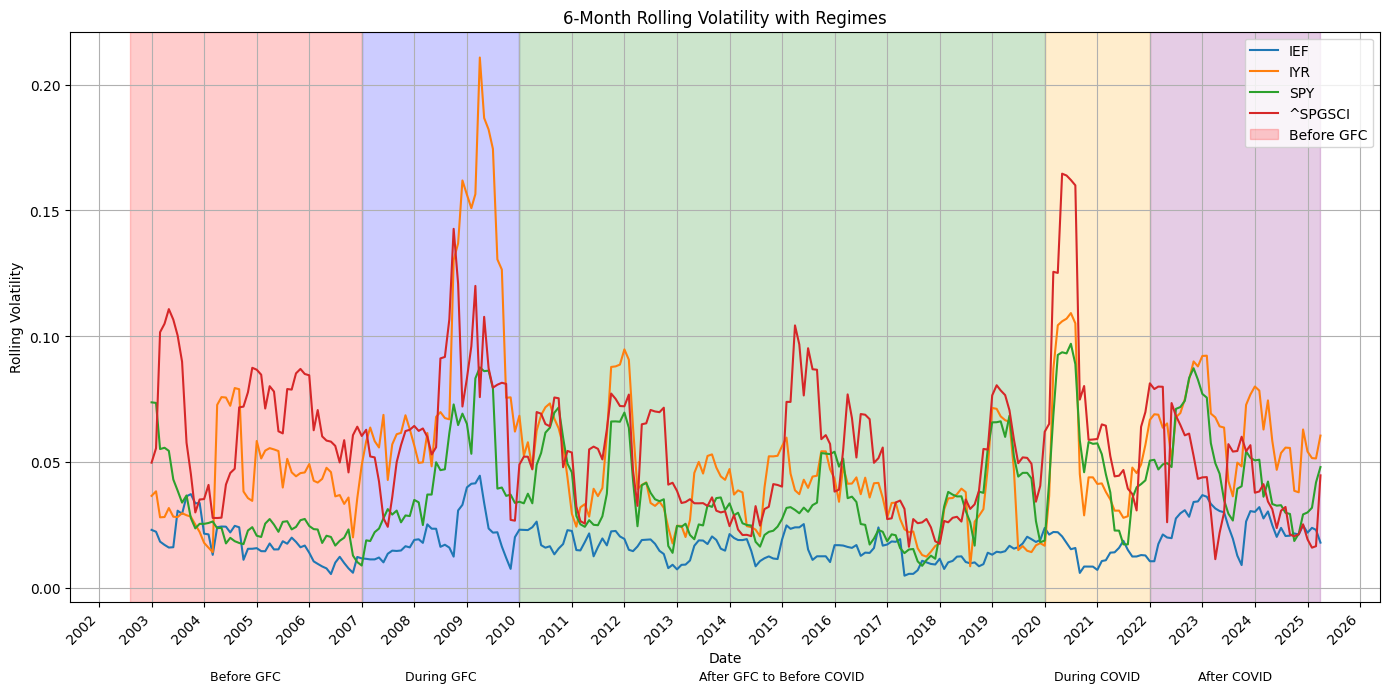

In [31]:
rolling_vol = returns.rolling(window=6).std()

def plot_rolling_volatility_with_regimes(rolling_vol, regimes):
    fig, ax = plt.subplots(figsize=(14, 7))

    for asset in rolling_vol.columns:
        ax.plot(rolling_vol.index, rolling_vol[asset], label=asset)

    # Color the background based on regimes
    for i, (regime_name, (start_date, end_date)) in enumerate(regimes.items()):
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)

        # Use a color cycle for better visual distinction
        colors = ['red', 'blue', 'green', 'orange', 'purple']
        color = colors[i % len(colors)]

        ax.axvspan(start_date, end_date, color=color, alpha=0.2, label=regime_name if i == 0 else "")

        # Add regime label below the year on the x-axis
        # Find a suitable x-coordinate within the regime's span
        regime_midpoint = (start_date + (end_date-start_date)/2)
        ax.text(regime_midpoint, ax.get_ylim()[0] - (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.12, regime_name,
                ha='center', va='top', rotation=0, fontsize=9)

    ax.set_xlabel("Date")
    ax.set_ylabel("Rolling Volatility")
    ax.set_title("6-Month Rolling Volatility with Regimes")
    ax.legend()
    ax.grid(True)
    # Improve date formatting on x-axis
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()  # Adjust plot layout
    plt.show()

plot_rolling_volatility_with_regimes(rolling_vol, regimes)


                  Max Return (Vol ≤ 10%)  Min Volatility (Return ≥ 4%)  Max Sharpe Ratio
US_10Yr_Treasury                    2.23                         64.76             35.89
US_REITs                           50.92                          0.00             21.89
US_Equities                        21.01                         30.22             27.35
US_Commodities                     25.84                          5.03             14.87
Return (%)                         19.09                          7.68             12.80
Volatility (%)                     10.00                          4.71              6.30
Sharpe Ratio                        1.91                          1.63              2.03
                  Max Return (Vol ≤ 10%)  Min Volatility (Return ≥ 4%)  Max Sharpe Ratio
US_10Yr_Treasury                  100.00                         81.69             88.29
US_REITs                            0.00                          0.00              0.00
US_Equities          

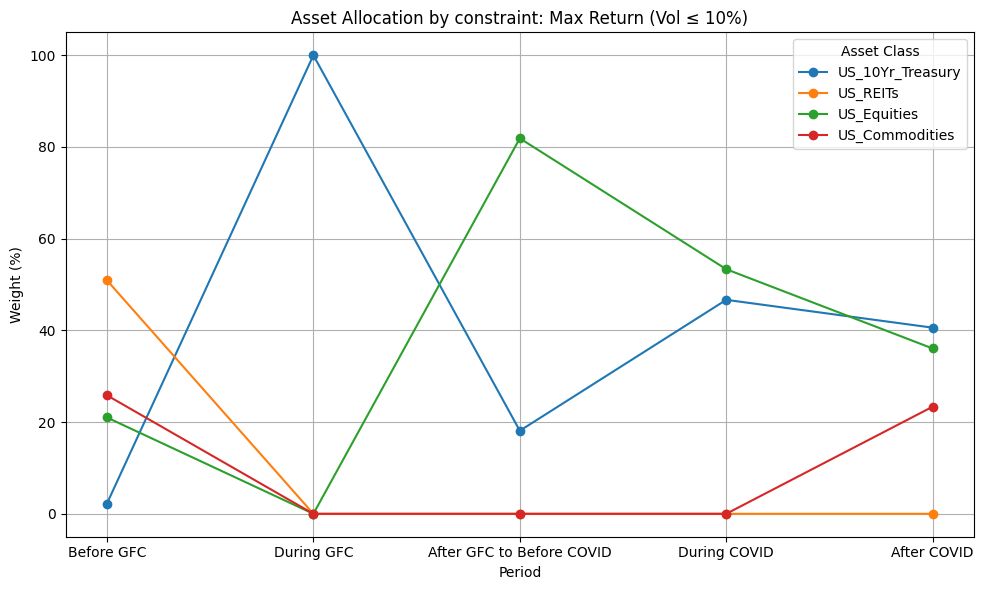

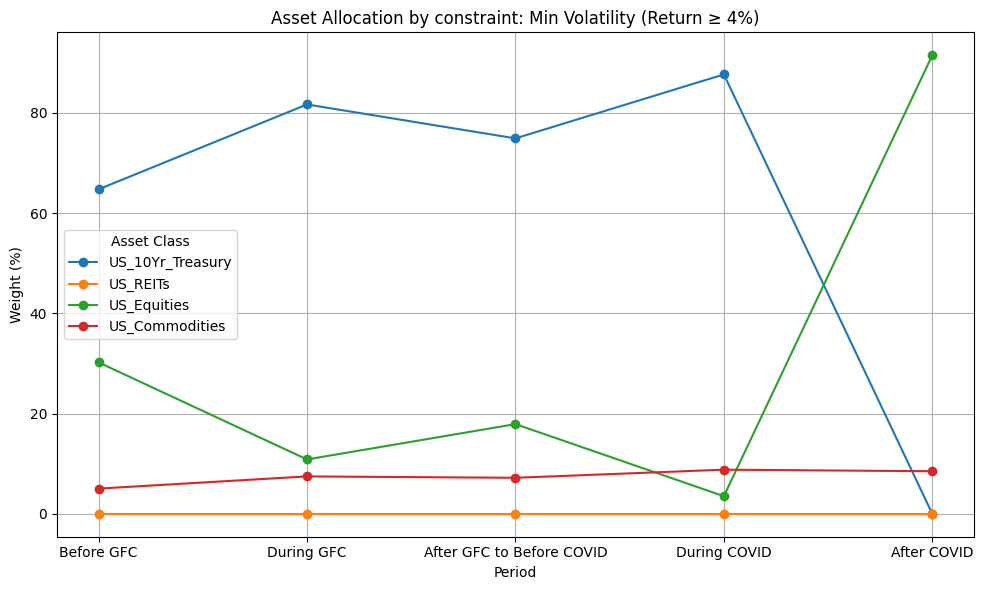

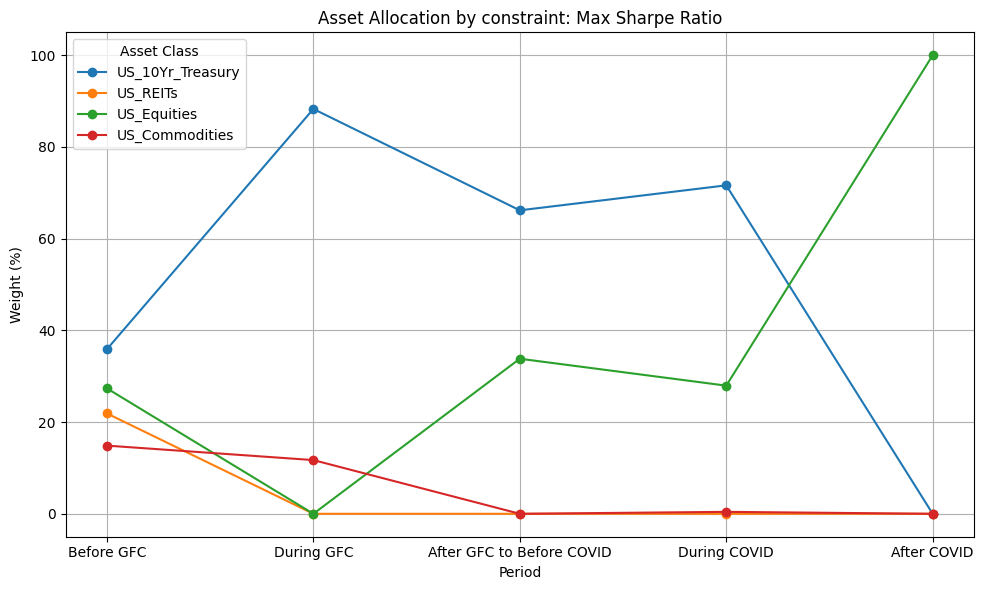

In [32]:
portfolio_weights_by_regime = {
    'Max Return (Vol ≤ 10%)': {},
    'Min Volatility (Return ≥ 4%)': {},
    'Max Sharpe Ratio': {}
}


for regime_name, (start, end) in regimes.items():
    regime_returns = returns.loc[start:end].dropna()

    n_months = len(regime_returns)
    annualized_reg_returns = (1 + regime_returns).prod()**(12 / n_months) - 1
    annualized_reg_cov = regime_returns.cov() * 12

    weights = run_optimization(annualized_reg_returns, annualized_reg_cov)

    for port_name in weights:
        portfolio_weights_by_regime[port_name][regime_name] = weights[port_name] * 100
asset_names = list(tickers.keys())


for strategy_name, weights_dict in portfolio_weights_by_regime.items():
    df = pd.DataFrame(weights_dict, index=asset_names).T
    plt.figure(figsize=(10, 6))
    for asset in df.columns:
        plt.plot(df.index, df[asset], marker='o', label=asset)

    plt.title(f"Asset Allocation by constraint: {strategy_name}")
    plt.ylabel('Weight (%)')
    plt.xlabel('Period')
    plt.legend(title='Asset Class')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

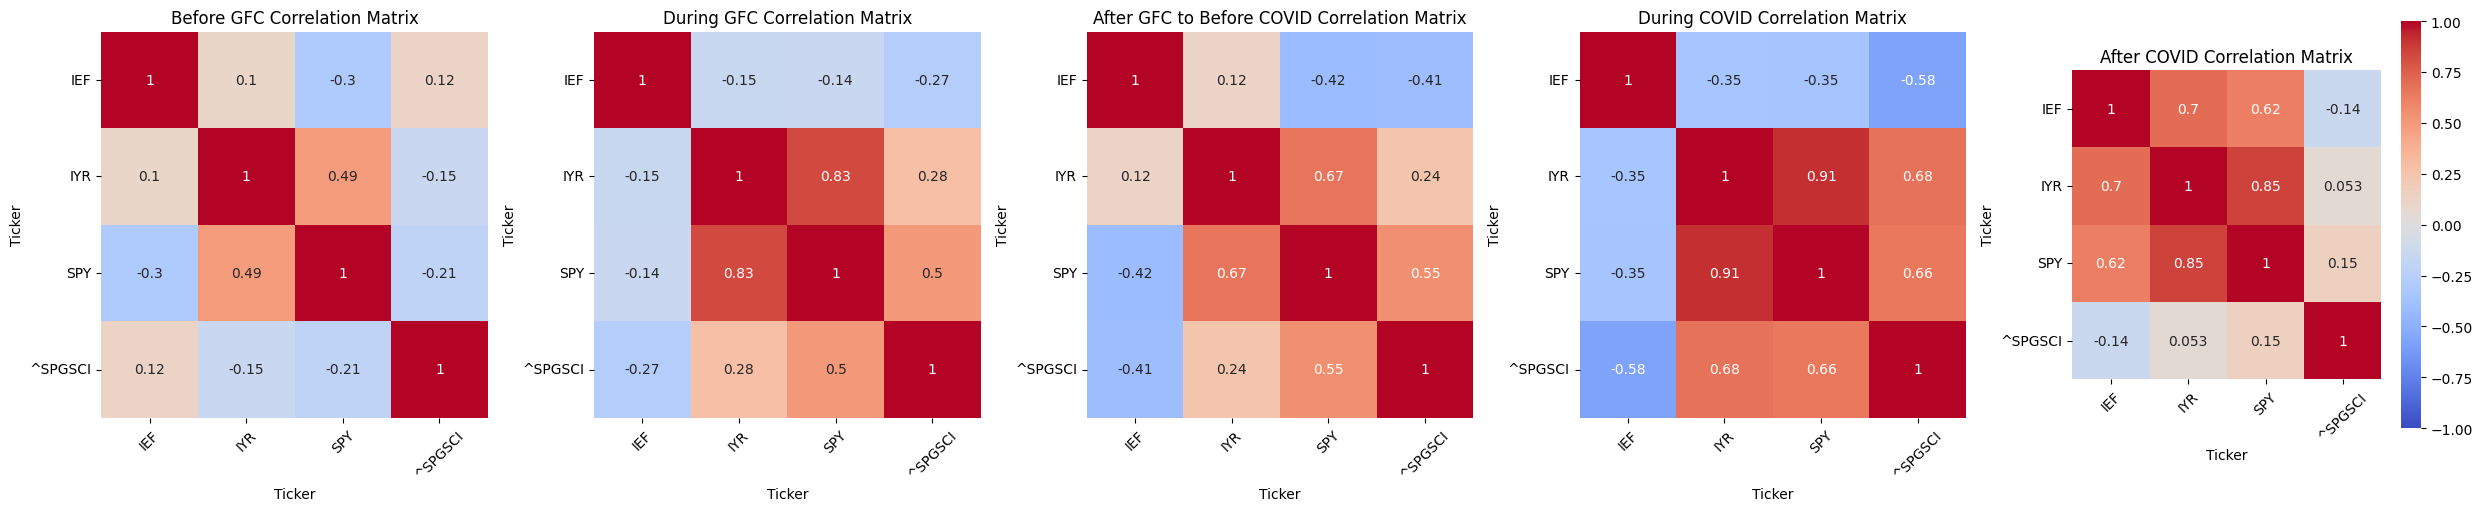

In [33]:
def plot_correlation_by_regime(returns, regimes):
    fig, axes = plt.subplots(1, len(regimes), figsize=(5 * len(regimes), 5))

    if len(regimes) == 1:
        axes = [axes]

    for i, (regime_name, (start, end)) in enumerate(regimes.items()):
        regime_returns = returns.loc[start:end].dropna()
        corr = regime_returns.corr()

        sns.heatmap(
            corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            ax=axes[i], cbar=(i == len(regimes) - 1), square=True
        )
        axes[i].set_title(f"{regime_name} Correlation Matrix")
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
        axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=0)

    plt.tight_layout()
    plt.show()

plot_correlation_by_regime(returns, regimes)

<span style="font-size:18px; color:Black;"> **Using the historical data, setup backtesting study for three risk-based optimal portfolios (equal weight, min vol, max diversification) for comparison and recommendation** </span>


Portfolio Performance Metrics:
                      Equal Weight Min Volatility Max Diversification
Total Return               1.97433       1.100666            1.103574
Annualized Return         0.056742       0.038298             0.03837
Annualized Volatility     0.417122       0.195736            0.209091
Sharpe Ratio              0.136033        0.19566             0.18351
Max Drawdown             -0.424037      -0.177227            -0.16383
VaR                      -0.051937      -0.024554           -0.028304
ES                       -0.001343      -0.001583            -0.00225

Average Portfolio Weights:
        Equal Weight Min Volatility Max Diversification
Ticker                                                 
IEF             0.25       0.757172            0.674667
IYR             0.25        0.00039            0.030209
SPY             0.25       0.155418            0.141058
^SPGSCI         0.25        0.08702            0.154065

Portfolio Recommendation Summary:
Best over

<Figure size 1200x600 with 0 Axes>

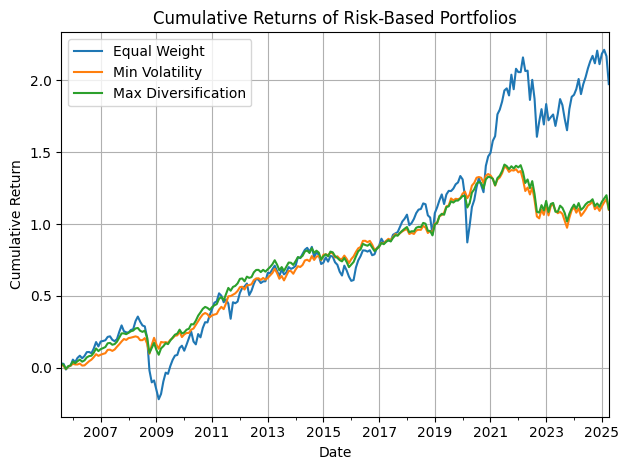

<Figure size 1200x600 with 0 Axes>

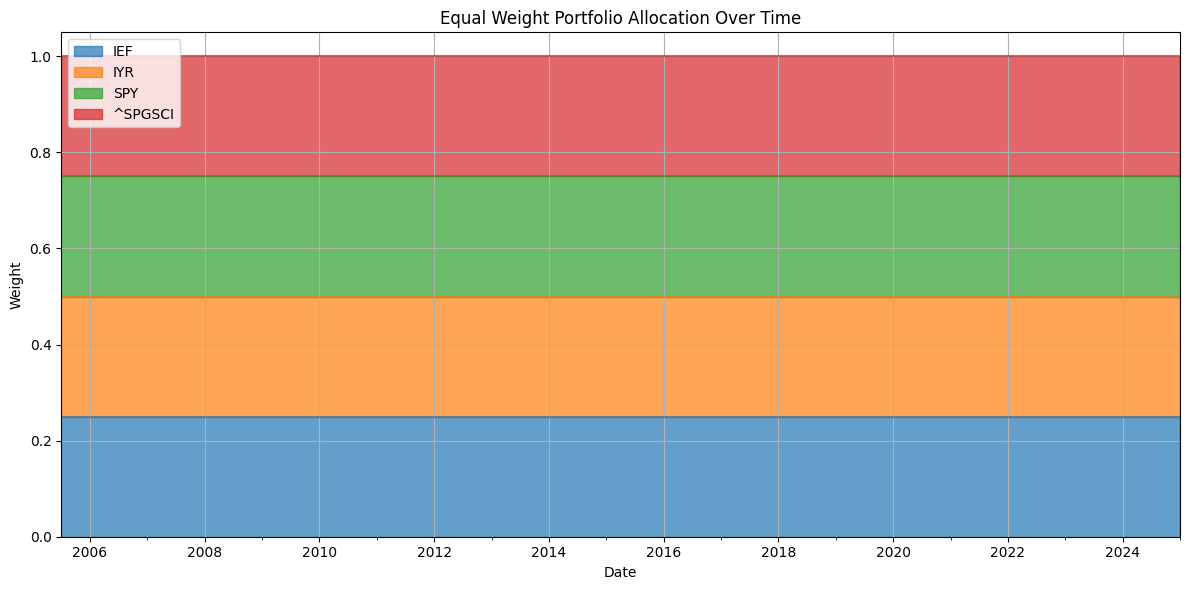

<Figure size 1200x600 with 0 Axes>

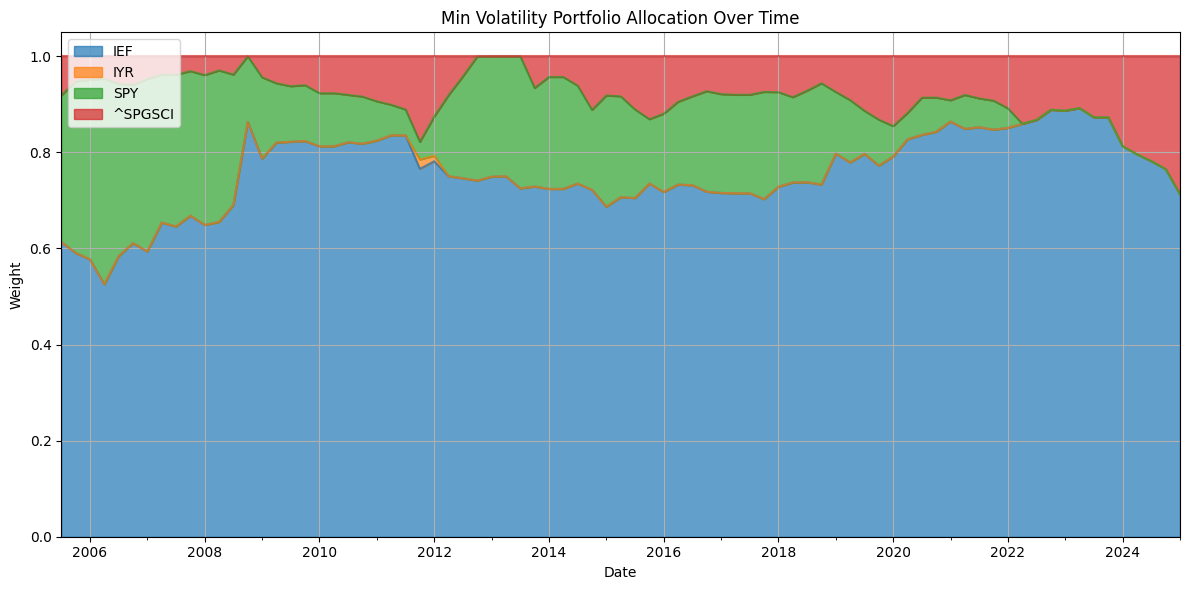

<Figure size 1200x600 with 0 Axes>

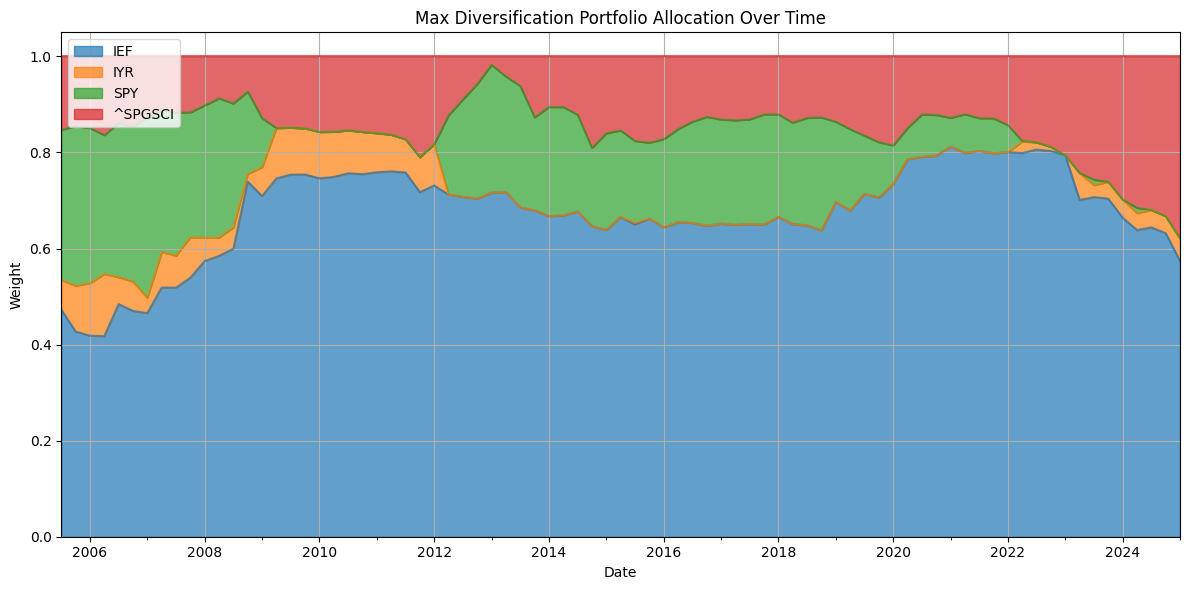

In [35]:
def calculate_portfolio_stats(window_returns):   ##calcaulte stats for window of returns
    annual_trading_month = 12
    observed_trading_month = window_returns.shape[0]

    # Annualized returns per asset
    annualized_returns = (1 + window_returns).prod() ** (annual_trading_month / observed_trading_month) - 1

    # Annualized covariance matrix
    annualized_covariance_matrix = window_returns.cov() * annual_trading_month

    return annualized_returns, annualized_covariance_matrix

def mean_portfolio(weights, returns):
    return np.dot(weights, returns)

def std_portfolio(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def diversification_ratio(weights, cov_matrix):
    weighted_stds = np.sum(weights * np.sqrt(np.diag(cov_matrix)))
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    div_ratio = weighted_stds / portfolio_std
    return -div_ratio  # Negate for maximization

# Backtest function
def backtest_portfolios(returns, window_size=36, rebalance_freq=3):

    num_assets = returns.shape[1]
    all_dates = returns.index
    rebalance_dates = []

    start_idx = window_size
    while start_idx < len(all_dates):
        rebalance_dates.append(all_dates[start_idx])
        start_idx += rebalance_freq

    portfolio_returns = pd.DataFrame(index=all_dates[window_size:],
                                    columns=['Equal Weight', 'Min Volatility', 'Max Diversification'])

    weights_history = {
        'Equal Weight': pd.DataFrame(index=rebalance_dates, columns=returns.columns),
        'Min Volatility': pd.DataFrame(index=rebalance_dates, columns=returns.columns),
        'Max Diversification': pd.DataFrame(index=rebalance_dates, columns=returns.columns)
    }

    constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(num_assets))

    current_weights = {
        'Equal Weight': np.array([1/num_assets] * num_assets),
        'Min Volatility': np.array([1/num_assets] * num_assets),
        'Max Diversification': np.array([1/num_assets] * num_assets)
    }

    for i, current_date in enumerate(all_dates[window_size:]):
        if current_date in rebalance_dates:
            end_idx = np.where(all_dates == current_date)[0][0]
            start_idx = end_idx - window_size
            window_returns = returns.iloc[start_idx:end_idx]

            ann_returns, ann_cov_matrix = calculate_portfolio_stats(window_returns)
            current_weights['Equal Weight'] = np.array([1/num_assets] * num_assets)

            min_vol_result = minimize(
                fun=lambda x: std_portfolio(x, ann_cov_matrix),
                x0=current_weights['Min Volatility'],
                method='SLSQP',
                bounds=bounds,
                constraints=constraint
            )
            current_weights['Min Volatility'] = min_vol_result.x

            max_div_result = minimize(
                fun=lambda x: diversification_ratio(x, ann_cov_matrix),
                x0=current_weights['Max Diversification'],
                method='SLSQP',
                bounds=bounds,
                constraints=constraint
            )
            current_weights['Max Diversification'] = max_div_result.x

            for strategy in weights_history:
                weights_history[strategy].loc[current_date] = current_weights[strategy]

        current_month_return = returns.loc[current_date]
        for strategy in portfolio_returns.columns:
            portfolio_returns.loc[current_date, strategy] = np.dot(current_weights[strategy], current_month_return)

    return portfolio_returns, weights_history

def calculate_cumulative_returns(returns):
    """Calculate cumulative returns from monthly returns"""
    return (1 + returns).cumprod() - 1

def calculate_performance_metrics(returns):
    annual_factor = 12
    total_return = calculate_cumulative_returns(returns).iloc[-1]

    years = len(returns) / annual_factor
    annualized_return = (1 + total_return) ** (1 / years) - 1
    annualized_volatility = returns.std() * (annual_factor)
    sharpe_ratio = annualized_return / annualized_volatility

    cum_returns = calculate_cumulative_returns(returns)
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / (1 + running_max)
    max_drawdown = drawdown.min()
    confidence_level = 0.95
    var = returns.quantile(1 - confidence_level)
    es = -returns[returns < -var].mean()  # Expected Shortfall (Conditional VaR)


    metrics = pd.DataFrame({
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'VaR': var,
        'ES': es

    })

    return metrics

window_size = 36  # 3 years of data for estimation
rebalance_freq = 3  # Quarterly rebalancing

portfolio_returns, weights_history = backtest_portfolios(returns, window_size, rebalance_freq)

cumulative_returns = calculate_cumulative_returns(portfolio_returns)
performance_metrics = calculate_performance_metrics(portfolio_returns)

print("\nPortfolio Performance Metrics:")
print(performance_metrics.T.round(4))

plt.figure(figsize=(12, 6))
cumulative_returns.plot()
plt.title('Cumulative Returns of Risk-Based Portfolios')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('cumulative_returns.png')

for strategy, weights_df in weights_history.items():
    plt.figure(figsize=(12, 6))
    weights_df.plot.area(figsize=(12, 6), alpha=0.7)
    plt.title(f'{strategy} Portfolio Allocation Over Time')
    plt.xlabel('Date')
    plt.ylabel('Weight')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(f'{strategy}_weights.png')

average_weights = {strategy: weights_df.mean() for strategy, weights_df in weights_history.items()}
avg_weights_df = pd.DataFrame(average_weights)
print("\nAverage Portfolio Weights:")
print(avg_weights_df.round(4))


print("\nPortfolio Recommendation Summary:")
best_sharpe = performance_metrics['Sharpe Ratio'].idxmax()
best_return = performance_metrics['Annualized Return'].idxmax()
lowest_vol = performance_metrics['Annualized Volatility'].idxmin()
smallest_drawdown = performance_metrics['Max Drawdown'].idxmax()  # Max because drawdown is negative
lowest_VaR = performance_metrics['VaR'].idxmax()
lowest_ES = performance_metrics['ES'].idxmax()

print(f"Best overall Sharpe ratio: {best_sharpe}")
print(f"Best overall return: {best_return}")
print(f"Lowest volatility: {lowest_vol}")
print(f"Smallest maximum drawdown: {smallest_drawdown}")
print(f"Lowest VaR: {lowest_VaR}")
print(f"Lowest Expected Shortfall: {lowest_ES}")

In [37]:
portfolio_returns.head()

,Equal Weight,Min Volatility,Max Diversification
Date,,,
2005-08-01,0.031159,0.022102,0.027853
2005-09-01,-0.003456,-0.00882,-0.006235
2005-10-01,-0.037959,-0.02171,-0.028473
2005-11-01,0.020222,0.01841,0.0193
2005-12-01,0.006049,0.005464,0.005906


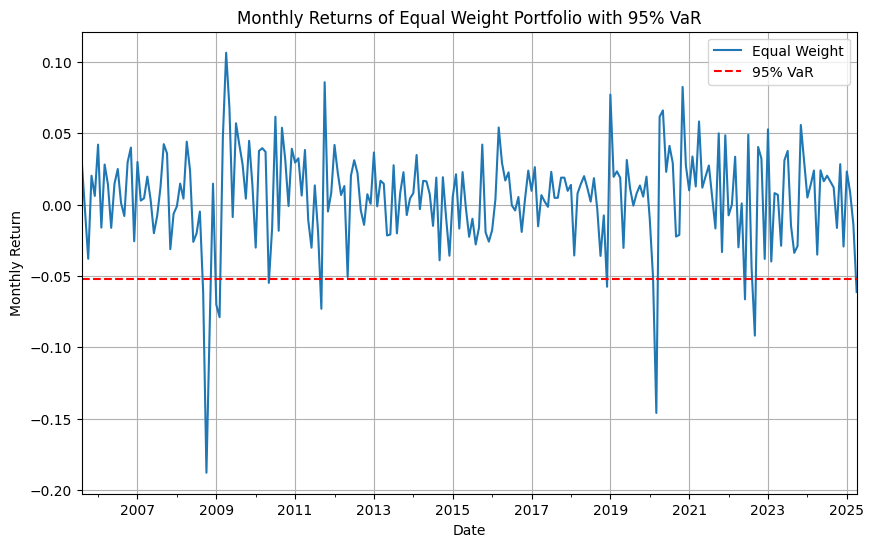

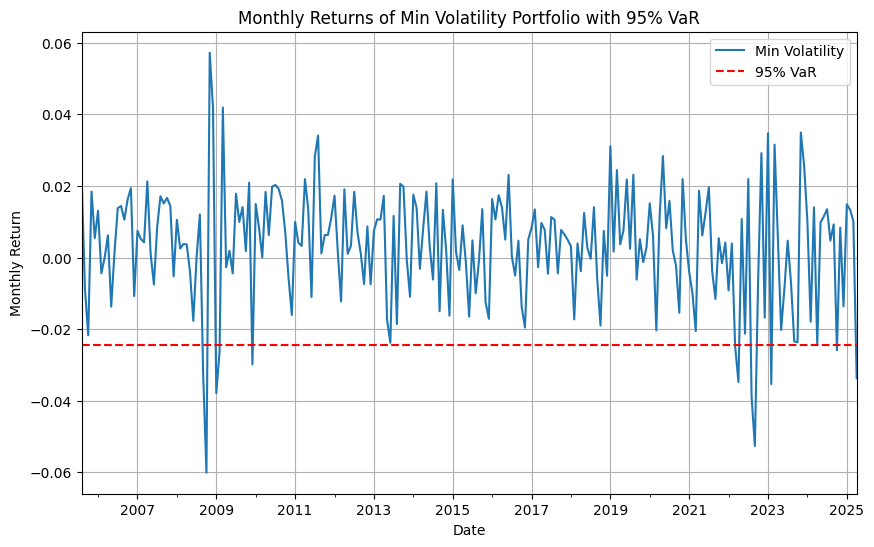

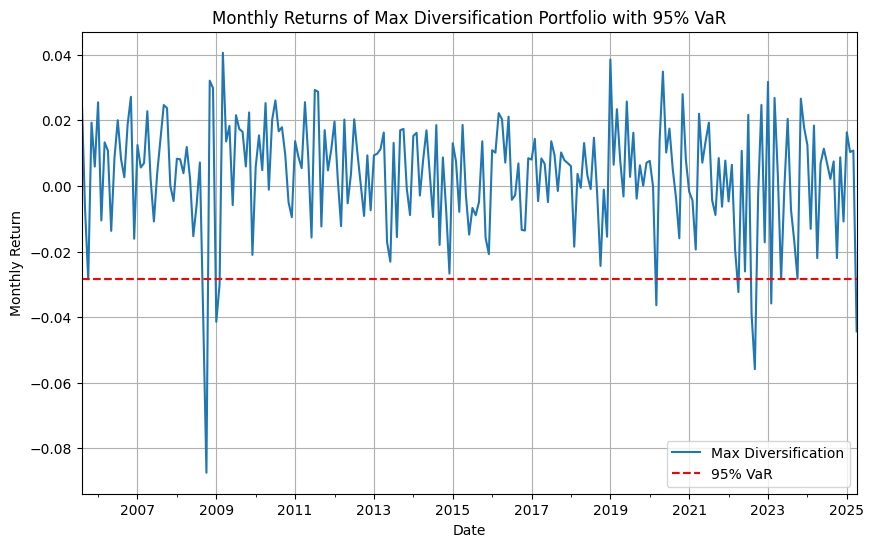

In [39]:
for portfolio in portfolio_returns.columns:
    plt.figure(figsize=(10, 6))
    portfolio_returns[portfolio].plot(label=portfolio)

    # Calculate and plot the 95% confidence VaR line
    var_95 = portfolio_returns[portfolio].quantile(0.05)  # 5th percentile for 95% VaR
    plt.axhline(y=var_95, color='red', linestyle='--', label='95% VaR')

    plt.title(f'Monthly Returns of {portfolio} Portfolio with 95% VaR')
    plt.xlabel('Date')
    plt.ylabel('Monthly Return')
    plt.legend()
    plt.grid(True)
    plt.show()
